# Imports

In [1]:
import sys
from pathlib import Path

AVES_ROOT = Path("../..") if not "google.colab" in sys.modules else Path("aves_git")
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
# mpl.rcParams["figure.dpi"] = 150
# esto depende de las fuentes que tengas instaladas en el sistema.
# mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

# Carga de Datos (EOD y areas verdes)

In [2]:
from aves.data import eod
#load
EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"

hogares = eod.read_homes(EOD_PATH)
personas = eod.read_people(EOD_PATH)
viajes = eod.read_trips(EOD_PATH)

# print columns
print("hogares: \n", hogares.columns)
print("personas: \n", personas.columns)
print("viajes: \n", viajes.columns)

hogares: 
 Index(['Hogar', 'Sector', 'Zona', 'Comuna', 'DirCoordX', 'DirCoordY', 'Fecha',
       'DiaAsig', 'TipoDia', 'Temporada', 'NumPer', 'NumVeh', 'NumBicAdulto',
       'NumBicNino', 'Propiedad', 'MontoDiv', 'ImputadoDiv', 'MontoArr',
       'ImputadoArr', 'IngresoHogar', 'FactorHogar'],
      dtype='object')
personas: 
 Index(['Hogar', 'Persona', 'AnoNac', 'Sexo', 'Relacion', 'Viajes',
       'LicenciaConducir', 'PaseEscolar', 'AdultoMayor', 'Estudios', 'Curso',
       'Actividad', 'Ocupacion', 'ActividadEmpresa', 'JornadaTrabajo',
       'DondeEstudia', 'DirActividadCoordX', 'DirActividadCoordY',
       'DirEstudiosCoordX', 'DirEstudiosCoordY', 'NoViaja', 'TarjetaBip',
       'Tarjeta2Bip', 'MedioViajeRestricion', 'ConoceTransantiago',
       'NoUsaTransantiago', 'Discapacidad', 'TieneIngresos', 'Ingreso',
       'TramoIngreso', 'IngresoFinal', 'TramoIngresoFinal', 'IngresoImputado',
       'Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal',
       'Factor_La

In [3]:
# Load
areas_verdes = (
    gpd.read_file(AVES_ROOT / "data" / "project" / "Superficie_de_Areas_Verdes_Santiago.geojson")
)
print("areas_verdes: \n", areas_verdes.columns)

areas_verdes: 
 Index(['FID', 'comuna', 'estado', 'area_m2', 'area_ha', 'estado_2', 'id',
       'shapearea', 'layer', 'shape_leng', 'shape_area', 'clase',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')


## Arreglos a los datos

In [21]:
# corregimos nombres de columna
areas_verdes = areas_verdes.rename(columns={"comuna": "Comuna"})
# corregimos comunas con distinto nombre
areas_verdes["Comuna"] = areas_verdes["Comuna"].replace(["ESTACION CENTRA", "NUNOA", "PAC", "PENALOLEN"], ["ESTACION CENTRAL", "ÑUÑOA", "PEDRO AGUIRRE CERDA", "PEÑALOLEN"])
# cambiamos areas_verdes con clase "AV PARQUE" a "PARQUE"
areas_verdes["clase"] = areas_verdes["clase"].replace(["AV PARQUE"], ["PARQUE"])
# cambiamos areas_verdes con estado "DESAFECTADA e" a "DESAFECTADA"
areas_verdes["estado"] = areas_verdes["estado"].replace(["DESAFECTADA VERDE e"], ["DESAFECTADA VERDE"])

print("Comunas no presentes en areas_verdes: \n", set(hogares["Comuna"]) - set(areas_verdes["Comuna"]))

# filtramos hogares por comunas presentes en areas_verdes
hogares = hogares[hogares["Comuna"].isin(areas_verdes["Comuna"].unique())]

Comunas no presentes en areas_verdes: 
 set()


# Visualizaciones

## Superficie y cantidad de areas verdes por comuna

,Comuna,clase,area_m2,n_areas,area_ha
0,CERRILLOS,BANDEJON,51218.342,39,5.121834
1,CERRILLOS,CAMPO DEPORTIVO,437046.097,5,43.704610
2,CERRILLOS,PARQUE,566657.890,2,56.665789
3,CERRILLOS,PLAZA,257345.039,87,25.734504
4,CERRILLOS,VEREDA,36666.459,58,3.666646
...,...,...,...,...,...
145,ÑUÑOA,BANDEJON,146049.146,126,14.604915
146,ÑUÑOA,CAMPO DEPORTIVO,636003.733,1,63.600373
147,ÑUÑOA,PARQUE,50444.613,5,5.044461
148,ÑUÑOA,PLAZA,536582.664,190,53.658266


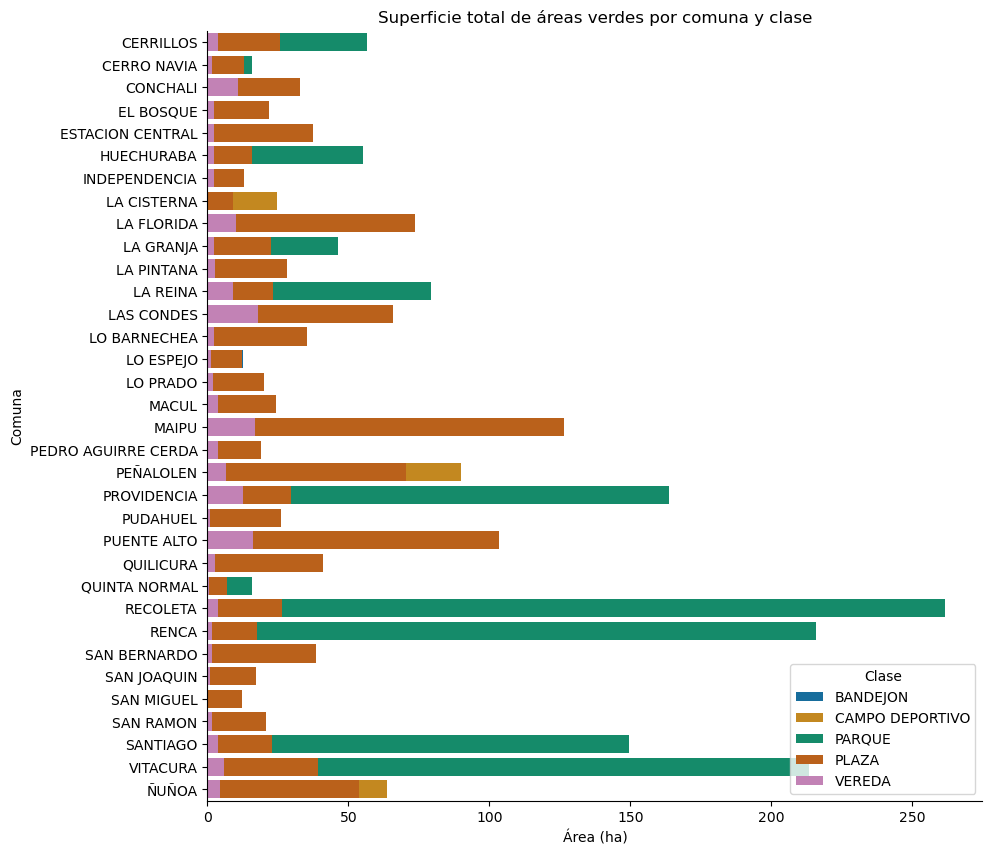

In [13]:
area_comuna_clase = areas_verdes.groupby(["Comuna", "clase"]).agg({"area_m2": "sum", "Comuna": "count"}).rename(columns={"Comuna": "n_areas"}).reset_index()
area_comuna_clase["area_ha"] = area_comuna_clase["area_m2"] / 10000

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=area_comuna_clase,
    x="area_ha",
    y="Comuna",
    hue="clase",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Área (ha)")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y clase")
ax.legend(title="Clase", loc="lower right")
sns.despine()

area_comuna_clase

,Comuna,estado,area_m2,n_areas,area_ha
0,CERRILLOS,CONSOLIDADA,145777.509,40,14.577751
1,CERRILLOS,DESAFECTADA ERIAZO,6019.921,6,0.601992
2,CERRILLOS,DESAFECTADA VERDE,1164851.979,142,116.485198
3,CERRILLOS,DETERIORADA,32284.418,3,3.228442
4,CERRO NAVIA,CONSOLIDADA,69819.898,24,6.981990
...,...,...,...,...,...
155,ÑUÑOA,CONSOLIDADA,505351.155,128,50.535115
156,ÑUÑOA,DESAFECTADA ERIAZO,2384.013,1,0.238401
157,ÑUÑOA,DESAFECTADA VERDE,901415.296,256,90.141530
158,ÑUÑOA,DETERIORADA,208.140,1,0.020814


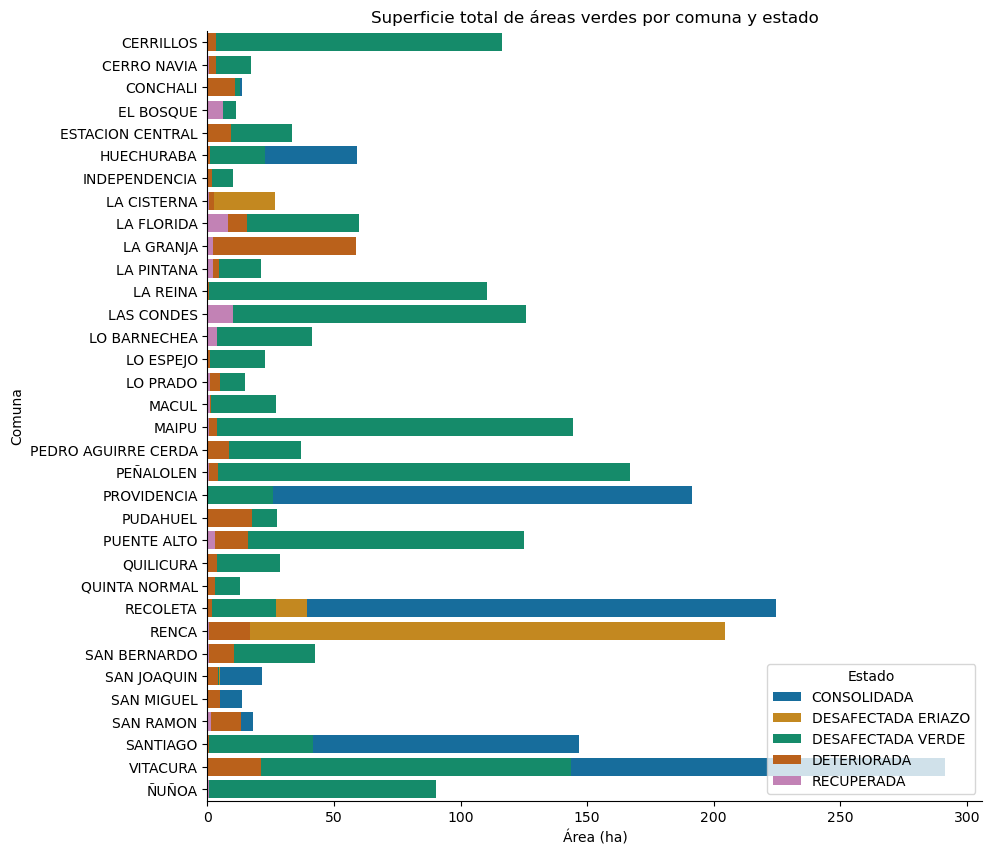

In [22]:
cantidad_comuna_estado = areas_verdes.groupby(["Comuna", "estado"]).agg({"area_m2": "sum", "Comuna": "count"}).rename(columns={"Comuna": "n_areas"}).reset_index()
cantidad_comuna_estado["area_ha"] = cantidad_comuna_estado["area_m2"] / 10000

# plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(
    data=cantidad_comuna_estado,
    x="area_ha",
    y="Comuna",
    hue="estado",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Área (ha)")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y estado")
ax.legend(title="Estado", loc="lower right")
sns.despine()

cantidad_comuna_estado

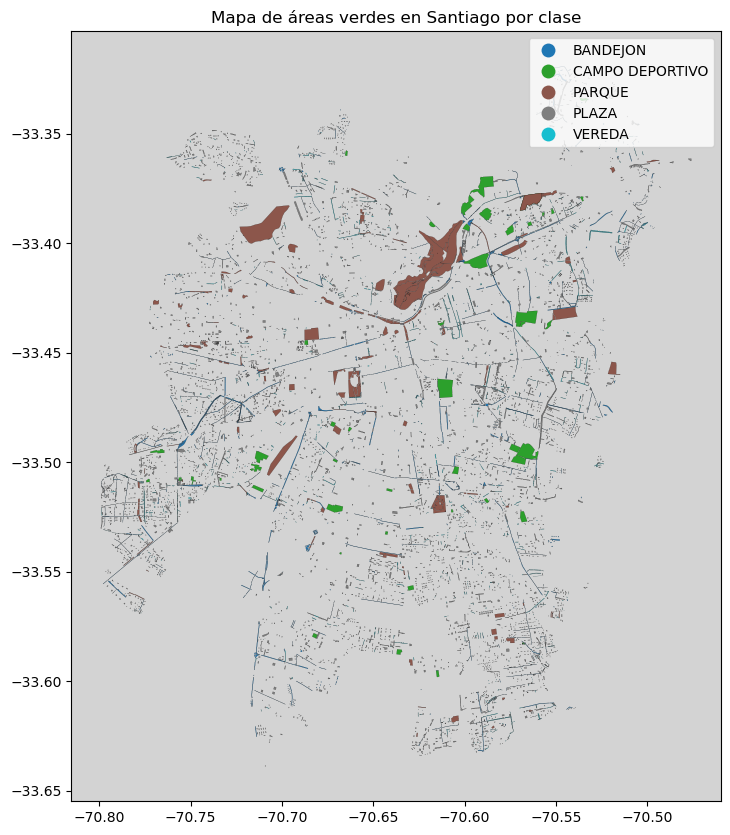

In [33]:
ax = areas_verdes.plot(figsize=(10, 10), column='clase', legend=True, edgecolor="black", linewidth=0.1)
ax.set_title("Mapa de áreas verdes en Santiago por clase")
ax.set_facecolor("lightgray")

(265, 15)


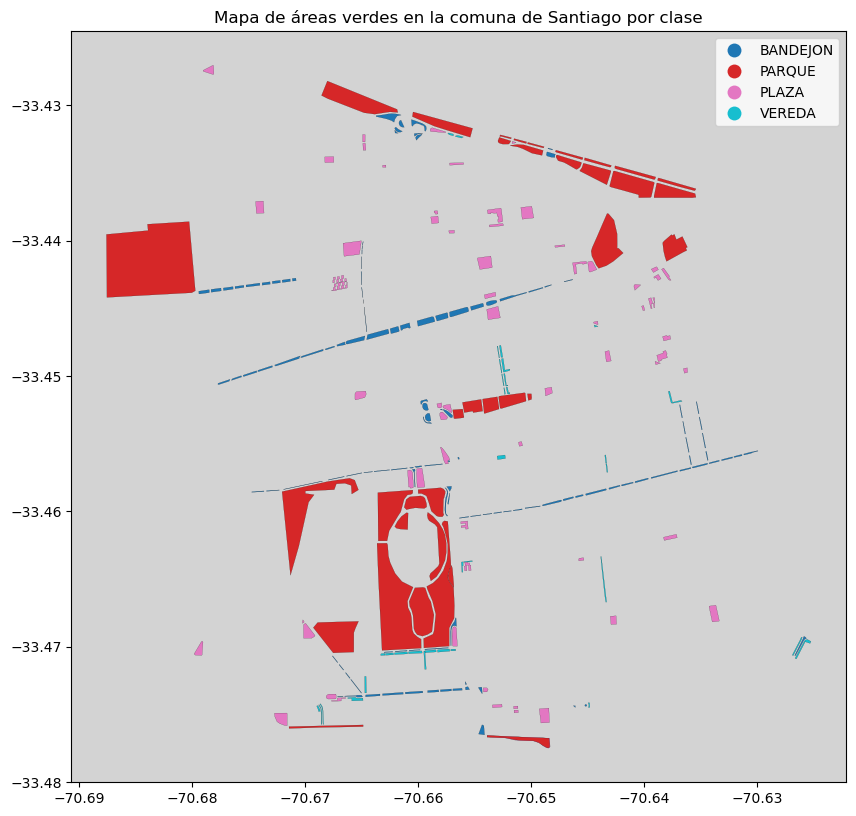

In [35]:
areas_verdes_santiago = areas_verdes[areas_verdes['Comuna'] == 'SANTIAGO']
print(areas_verdes_santiago.shape)
ax = areas_verdes_santiago.plot(figsize=(10, 10), column='clase', legend=True, edgecolor="black", linewidth=0.1)
ax.set_title("Mapa de áreas verdes en la comuna de Santiago por clase")
ax.set_facecolor("lightgray")

### ¿Cantidad de Areas verdes se relaciona con la poblacion?
agregar grafico con areas verdes por cada 1000 habitantes

### ¿Cual es la superficie total de los tipos de areas verdes?
### ¿Y su promedio de superficie?

,area_m2,area_ha,area_km2
clase,,,
BANDEJON,3.960929e+06,396.092897,3.960929
CAMPO DEPORTIVO,6.257280e+06,625.728011,6.257280
PARQUE,1.496135e+07,1496.134607,14.961346
PLAZA,1.146003e+07,1146.003313,11.460033
VEREDA,1.611821e+06,161.182139,1.611821


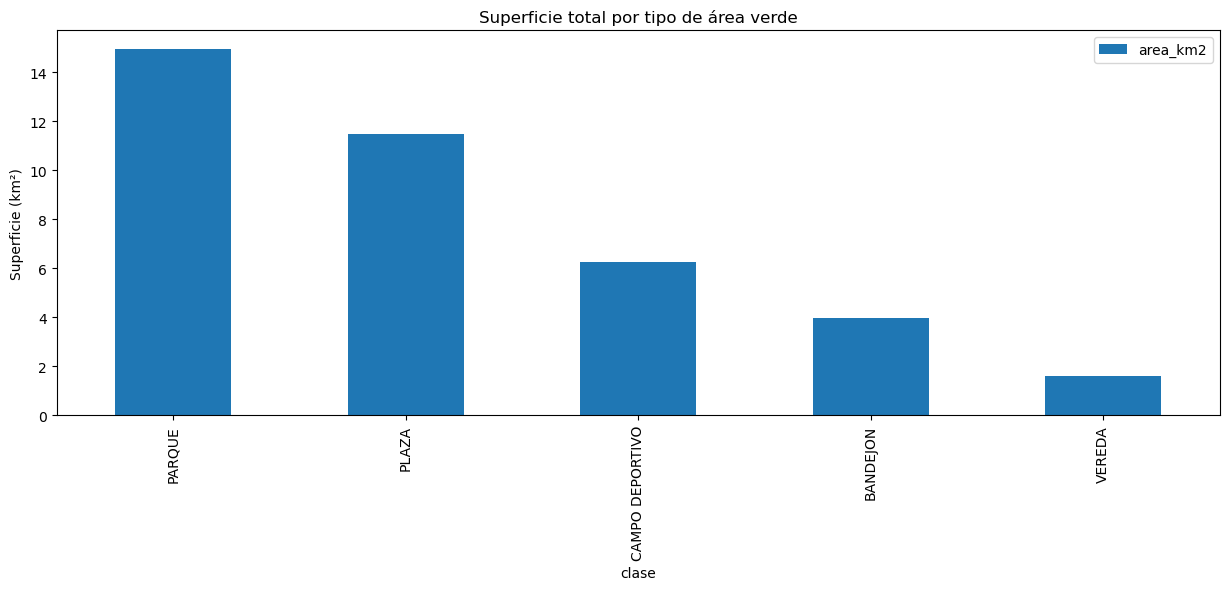

In [39]:
# superficie total por tipo de área verde
superficie_total_tipo = areas_verdes.groupby("clase").agg({"area_m2": "sum", "area_ha": "sum"})
superficie_total_tipo["area_km2"] = superficie_total_tipo["area_m2"] / 1e6
superficie_total_tipo.sort_values("area_km2", ascending=False).plot.bar(y="area_km2", figsize=(15, 5), title="Superficie total por tipo de área verde", ylabel="Superficie (km²)")
superficie_total_tipo

,area_m2,area_ha,area_km2
clase,,,
CAMPO DEPORTIVO,127699.596939,12.769959,0.127700
PARQUE,69912.832467,6.991283,0.069913
PLAZA,1773.449870,0.177345,0.001773
BANDEJON,1578.688413,0.157869,0.001579
VEREDA,680.667774,0.068067,0.000681


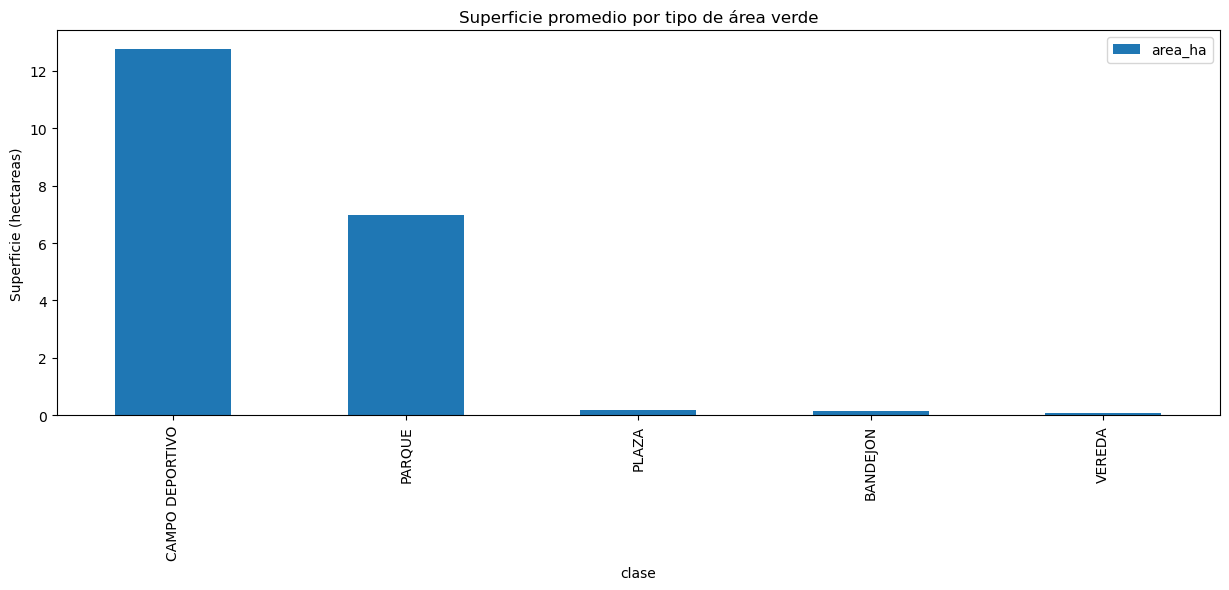

In [41]:
# promedio de superficie por tipo
superficie_promedio_tipo = areas_verdes.groupby("clase").agg({"area_m2": "mean", "area_ha": "mean"}).sort_values("area_ha", ascending=False)
superficie_promedio_tipo["area_km2"] = superficie_promedio_tipo["area_m2"] / 1e6
superficie_promedio_tipo.plot.bar(y="area_ha", figsize=(15, 5), title="Superficie promedio por tipo de área verde", ylabel="Superficie (hectareas)")
superficie_promedio_tipo

### ¿Flujo de personas cerca de cada areas verde?
### ¿Cuanta gente vive cerca de cada area verde?
### ¿Cuanta gente trabaja cerca de cada area verde?

### ¿Hay correlacion entre tasa de areas verdes por habitante e ingreso comunal promedio?

In [42]:
ingreso_por_comuna = (
    hogares.groupby("Comuna")
    .apply(
        lambda x: (x["FactorHogar"] * x["IngresoHogar"]).sum() / x["FactorHogar"].sum()
    )
    .rename("ingreso")
)

ingreso_por_comuna

Comuna
CERRILLOS              5.287505e+05
CERRO NAVIA            4.213678e+05
CONCHALI               6.050698e+05
EL BOSQUE              5.143629e+05
ESTACION CENTRAL       4.832393e+05
HUECHURABA             7.918456e+05
INDEPENDENCIA          6.057736e+05
LA CISTERNA            6.160750e+05
LA FLORIDA             7.147872e+05
LA GRANJA              5.591557e+05
LA PINTANA             4.193542e+05
LA REINA               1.521881e+06
LAS CONDES             1.460452e+06
LO BARNECHEA           2.182363e+06
LO ESPEJO              4.978187e+05
LO PRADO               4.596349e+05
MACUL                  7.739653e+05
MAIPU                  5.953841e+05
PEDRO AGUIRRE CERDA    5.462924e+05
PEÑALOLEN              7.617944e+05
PROVIDENCIA            1.370451e+06
PUDAHUEL               5.375919e+05
PUENTE ALTO            5.685155e+05
QUILICURA              5.940065e+05
QUINTA NORMAL          5.127847e+05
RECOLETA               6.350697e+05
RENCA                  5.203086e+05
SAN BERNARDO         

### ¿Cual es la distribucion de distancia o tiempo de viaje a areas verdes en distintos sectores de la ciudad?